In [322]:
# importing default packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
from causalimpact import CausalImpact


# Change the below path to point to the current project root directory
os.chdir('/Users/sravan/PycharmProjects/DATA-512-HCD/project/hcd_proj_individual_analysis')
os.getcwd()

'/Users/sravan/PycharmProjects/DATA-512-HCD/project/hcd_proj_individual_analysis'

## Step 0: Data Acquisition
In this step, we start by downloading and reading the data. The different data tables are then filtered, cleaned and stadardized to get the final confirmed daily infection rate.<br>
We will using and processing the below datasets,
1. COVID-19 fatality data from John
Hopkins University
https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_deaths.csv
2. New Haven Employment data https://www.bls.gov/eag/eag.ct_newhaven_mn.htm
3. COVID-19 Vaccinations in the New Haven County
https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-inthe-United-States-County/8xkx-amqh/data

### Data filtering and preprocessing

In [323]:
# Mask mandate data in the New Haven county
df_laborforce = pd.read_excel("data/laborforce_data-2018-2022.xlsx")
df_laborforce.head()

,Year,Period,labor force,employment,unemployment
0,2018,Jan,326808,311328,15480
1,2018,Feb,329469,314567,14902
2,2018,Mar,329444,315525,13919
3,2018,Apr,329649,317888,11761
4,2018,May,332520,320006,12514


In [324]:
# Collecting and processing employment labor force data
df_laborforce['Date'] = pd.to_datetime(df_laborforce['Period'] + df_laborforce['Year'].astype(str), format='%b%Y')
df_laborforce = df_laborforce.sort_values('Date').reset_index().drop(columns=['Year', 'Period', 'index'], axis=1)
df_laborforce = df_laborforce.melt(id_vars=['Date'], var_name='Employment_Status', value_name='Number_of_Persons')
df_laborforce['Number_of_Persons'] = df_laborforce['Number_of_Persons']
df_laborforce.head()

,Date,Employment_Status,Number_of_Persons
0,2018-01-01,labor force,326808
1,2018-02-01,labor force,329469
2,2018-03-01,labor force,329444
3,2018-04-01,labor force,329649
4,2018-05-01,labor force,332520


In [325]:
# Ingesting job availability data
df_total_emp = pd.read_csv("data/nonfarm_employment_data-2018-2022.csv")
df_total_emp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2018,283.2,286.9,285.6,290.2,291.9,292.7,287.0,285.3,291.0,293.7,296.1,297.2
1,2019,283.9,287.7,286.4,291.1,292.0,291.4,288.1,288.4,294.9,298.6,302.4,300.7
2,2020,291.3,292.7,289.7,249.4,258.7,268.9,271.7,275.5,283.0,286.1,286.6,285.5
3,2021,276.5,278.2,280.0,282.9,286.1,287.2,285.3,285.5,289.6,294.1,296.9,294.6
4,2022,284.9,289.4,290.6,292.5,292.9,295.5,293.4,291.0,298.0,NaN,NaN,NaN


In [326]:
# Processing job availability data
df_total_emp = df_total_emp.melt(id_vars=['Year'], var_name='Month', value_name='Number_of_Jobs')
df_total_emp = df_total_emp.dropna()
df_total_emp['Number_of_Jobs'] = df_total_emp['Number_of_Jobs'] * 1000
df_total_emp.head()

,Year,Month,Number_of_Jobs
0,2018,Jan,283200.0
1,2019,Jan,283900.0
2,2020,Jan,291300.0
3,2021,Jan,276500.0
4,2022,Jan,284900.0


In [327]:
# Converting individual year and month columns to date column and dropping nan values
df_total_emp['Date'] = pd.to_datetime(df_total_emp['Month'] + df_total_emp['Year'].astype(str), format='%b%Y')
df_total_emp = df_total_emp.sort_values('Date').reset_index().drop(columns=['Year', 'Month', 'index'], axis=1)
df_total_emp.head()

,Number_of_Jobs,Date
0,283200.0,2018-01-01
1,286900.0,2018-02-01
2,285600.0,2018-03-01
3,290200.0,2018-04-01
4,291900.0,2018-05-01


In [328]:
# Ingesting sector wise employment data and dropping invalid values
emp_by_sector = ['financial_activities_employment_data-2018-2022.csv',
 'information_employment_data-2018-2022.csv',
 'trade_transportation_utilities_employment_data-2018-2022.csv',
 'manufacturing_employment_data-2018-2022.csv',
 'government_employment_data-2018-2022.csv',
 'mining_logging_construction_employment_data-2018-2022.csv',
 'leisure_and_hospitality_employment_data-2018-2022.csv',
 'education_and_health_services_employment_data-2018-2022.csv',
 'professional_and_business_services_employment_data-2018-2022.csv',
 'other_services_employment_data-2018-2022.csv']
df_sector_emp = pd.DataFrame()

for sec in emp_by_sector:
    df_temp = pd.read_csv(f'data/{sec}').melt(id_vars=['Year'], var_name='Month', value_name='Number_of_Jobs')
    df_temp['Sector'] = sec.replace('_employment_data-2018-2022.csv', '')
    df_sector_emp = pd.concat([df_sector_emp, df_temp])

df_sector_emp['Date'] = pd.to_datetime(df_sector_emp['Month'] + df_sector_emp['Year'].astype(str), format='%b%Y')
df_sector_emp = df_sector_emp.sort_values(['Date', 'Sector']).reset_index().drop(columns=['Year', 'Month', 'index'], axis=1)
df_sector_emp = df_sector_emp.dropna()
df_sector_emp['Number_of_Jobs'] = df_sector_emp['Number_of_Jobs'] * 1000
df_sector_emp.head()

,Number_of_Jobs,Sector,Date
0,81100.0,education_and_health_services,2018-01-01
1,12100.0,financial_activities,2018-01-01
2,35700.0,government,2018-01-01
3,4500.0,information,2018-01-01
4,23900.0,leisure_and_hospitality,2018-01-01


In [329]:
# Confirmed cases data ingestion
df_conf_cases_us = pd.read_csv("data/RAW_us_confirmed_cases.csv")
df_conf_cases_us.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18511,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65973,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6930,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7575,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17320,17320,17320,17320,17320,17320


In [330]:
# Filtering confirmed cases for New Haven county
df_conf_cases_NH = df_conf_cases_us[(df_conf_cases_us["Province_State"] == "Connecticut")
                                    & (df_conf_cases_us["Admin2"] == "New Haven")]

# Extracting FIPS value of New Haven to filter other datasets

CT_NH_FIPS = df_conf_cases_NH['FIPS'].values[0]
print(f'STATE:\tConnecticut\nCOUNTY:\tNew Haven\nFIPS:\t{int(CT_NH_FIPS)}')
df_conf_cases_NH.head()

STATE:	Connecticut
COUNTY:	New Haven
FIPS:	9009


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22
327,Connecticut,New Haven,84009009,US,USA,840,9009.0,US,41.408032,-72.936204,...,239438,239502,239641,239806,239957,240154,240338,240382,240429,240549


In [331]:
# Extracting data for new haven cases by date and creating a separate dataframe
df_conf_cases = pd.DataFrame(df_conf_cases_NH.iloc[0][11:])
df_conf_cases = df_conf_cases.reset_index()
df_conf_cases.columns = ["Date", "Number_of_Cases"]
df_conf_cases['Date'] = pd.to_datetime(df_conf_cases["Date"])
df_conf_cases.head()

,Date,Number_of_Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [332]:
# Mask mandate data in the New Haven county
df_mask_mandate= pd.read_csv("data/CT_NewHaven_mask_mandate.csv")

# Assuming the missing values as No, meaning people were not mandated to wear masks
df_mask_mandate["Face_Masks_Required_in_Public"] = df_mask_mandate["Face_Masks_Required_in_Public"]
df_mask_mandate = df_mask_mandate[['date', 'Face_Masks_Required_in_Public']]
df_mask_mandate["Date"] = pd.to_datetime(df_mask_mandate["date"])
df_cases_masks = pd.merge(df_conf_cases, df_mask_mandate, how = 'left').fillna('No').drop('date', axis=1)
df_cases_masks.head()

,Date,Number_of_Cases,Face_Masks_Required_in_Public
0,2020-01-22,0,No
1,2020-01-23,0,No
2,2020-01-24,0,No
3,2020-01-25,0,No
4,2020-01-26,0,No


In [333]:
# Data Aggregation for cases on month level
df_cases_masks = df_cases_masks.groupby(pd.DatetimeIndex(df_cases_masks.Date).to_period('M')).nth(0)
df_conf_cases.Number_of_Cases.shift(1).head()
df_cases_masks.head()

0    NaN
1      0
2      0
3      0
4      0
Name: Number_of_Cases, dtype: object

## Analysis and Visualization

The data description shows that most of the data is valid, so we will be proceeding with this final infections and masks dataset.

Text(0.5, 1.0, 'Confirmed cases by date')

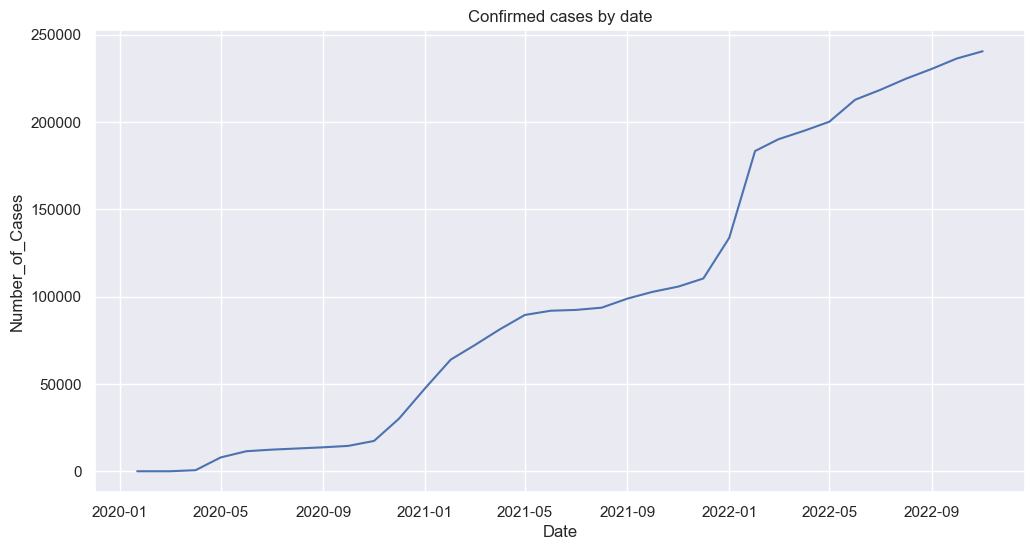

In [334]:
# Preliminary visualisations - confirmed cases by date
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(data=df_cases_masks, x='Date', y='Number_of_Cases')\
    .set_title("Confirmed cases by date")

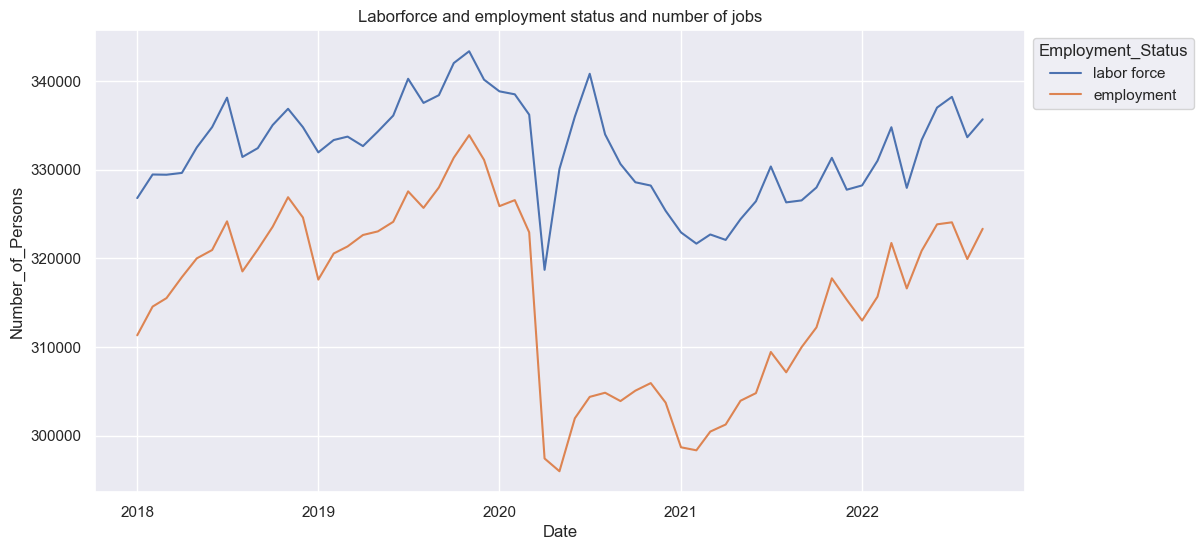

In [366]:
# Preliminary visualisations - laborforce available - employed and unemployed
sns.set(rc={'figure.figsize':(12,6)})
plt.title('Laborforce and employment status and number of jobs')
ax = sns.lineplot(data=df_laborforce[df_laborforce['Employment_Status']!='unemployment'], x="Date", y="Number_of_Persons", hue='Employment_Status')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

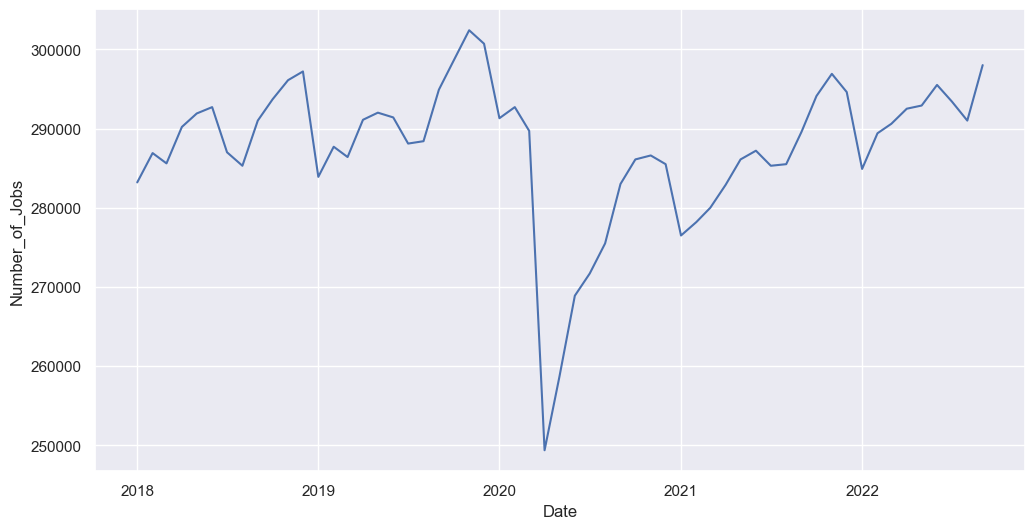

In [336]:
# Preliminary visualisations - Total employment
sns.set(rc={'figure.figsize':(12,6)})
ax = sns.lineplot(data=df_total_emp, x="Date", y="Number_of_Jobs")

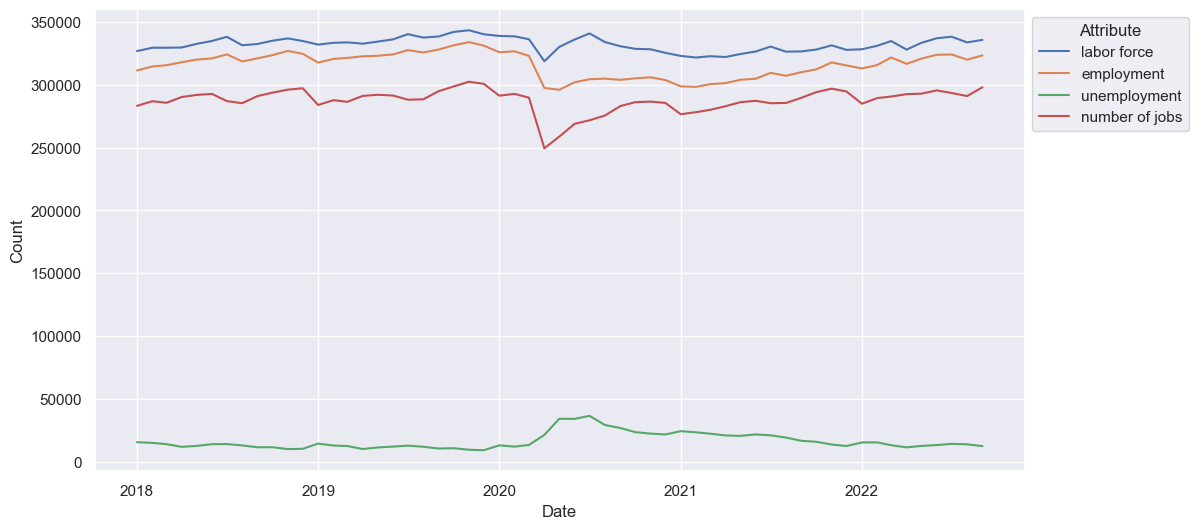

In [337]:
# Employment metrics by attribute
df1 = df_laborforce.copy()
df1 = df1.rename(columns={'Employment_Status': 'Attribute'})
df1 = df1.rename(columns={'Number_of_Persons': 'Count'})
df2 = df_total_emp.copy()
df2['Attribute'] = 'number of jobs'
df2 = df2.rename(columns={'Number_of_Jobs': 'Count'})
df2 = df2[['Date', 'Attribute', 'Count']]
df2.head()
df_laborforce_jobs = pd.concat([df1, df2])
df_laborforce_jobs = df_laborforce_jobs.reset_index()

plt.title('Employment, Unemployment, Job availability, Labor force trends in New Haven, CT')
plt.suptitle('Employment variation by attribute')

sns.set(rc={'figure.figsize':(12,6)})
ax = sns.lineplot(data=df_laborforce_jobs, x="Date", y="Count", hue='Attribute')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

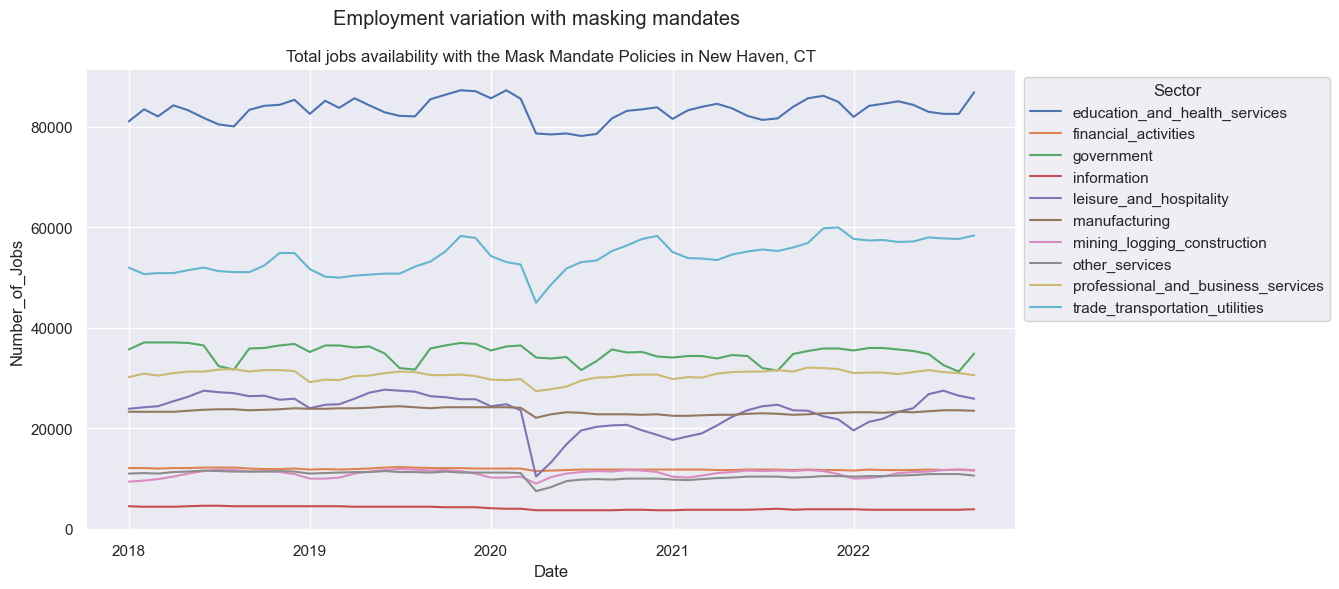

In [363]:
# Preliminary visualisations - Sector wise employment
sns.set(rc={'figure.figsize':(12,6)})

plt.title('Total jobs availability with the Mask Mandate Policies in New Haven, CT')
plt.suptitle('Employment variation with masking mandates')
ax = sns.lineplot(data=df_sector_emp, x="Date", y="Number_of_Jobs", hue='Sector')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [339]:
# Finding the masking policy change dates by using a shift (lead) function in pandas
df_cases_masks['lead_day_mask_status'] = df_cases_masks['Face_Masks_Required_in_Public'].shift(-1)

df_mask_mandate_change = df_cases_masks[df_cases_masks['lead_day_mask_status'] != df_cases_masks['Face_Masks_Required_in_Public']]

df_cases_masks = df_cases_masks.fillna('No')\
    .drop(columns=['lead_day_mask_status'])

df_mask_mandate_change.dropna()

,Date,Number_of_Cases,Face_Masks_Required_in_Public,lead_day_mask_status
Date,,,,
2020-04,2020-04-01,611,No,Yes
2021-08,2021-08-01,93680,Yes,No


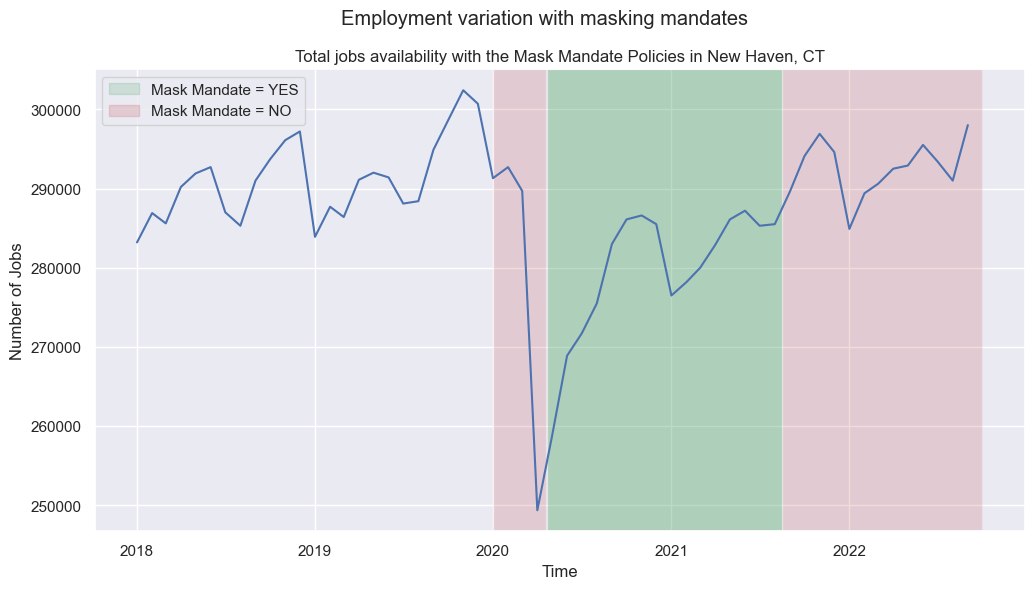

In [340]:
# Visualizing job availability trend with mask mandates status

import matplotlib.patches as mpatches

plt.figure(figsize=(12,6))

sns.lineplot(data=df_total_emp, x='Date', y='Number_of_Jobs')

# Adding titles and labels for the visualization
plt.title('Total jobs availability with the Mask Mandate Policies in New Haven, CT')
plt.suptitle('Employment variation with masking mandates')
plt.xlabel('Time')
plt.ylabel('Number of Jobs')

# lighter red background = Mask mandate is NO
plt.axvspan('2020-01-01', '2020-04-19', facecolor='r', alpha=0.2)
plt.axvspan('2021-08-16', '2022-10-01', facecolor='r', alpha=0.2)
red_patch = mpatches.Patch(color='r', alpha=0.2, label='Mask Mandate = NO')

# lighter green background = Mask mandate is YES
plt.axvspan('2020-04-20', '2021-08-15', facecolor='g', alpha=0.4)
green_patch = mpatches.Patch(color='g', alpha=0.2, label='Mask Mandate = YES')


# Adding legends
plt.legend(handles=[green_patch, red_patch])

# Saving the above figure as a .png file
plt.savefig('part1_analysis_viz.png')

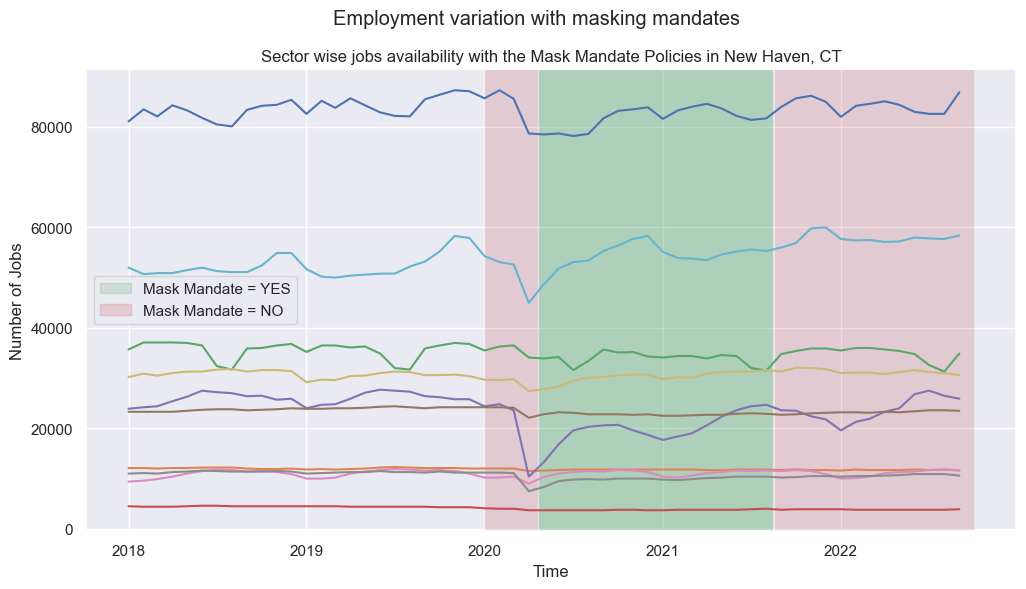

In [341]:
# Visualizing job availability trends across different employment sectors with mask mandates status

import matplotlib.patches as mpatches

plt.figure(figsize=(12,6))

ax = sns.lineplot(data=df_sector_emp, x="Date", y="Number_of_Jobs", hue='Sector')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Adding titles and labels for the visualization
plt.title('Sector wise jobs availability with the Mask Mandate Policies in New Haven, CT')
plt.suptitle('Employment variation with masking mandates')
plt.xlabel('Time')
plt.ylabel('Number of Jobs')

# lighter red background = Mask mandate is NO
plt.axvspan('2020-01-01', '2020-04-19', facecolor='r', alpha=0.2)
plt.axvspan('2021-08-16', '2022-10-01', facecolor='r', alpha=0.2)
red_patch = mpatches.Patch(color='r', alpha=0.2, label='Mask Mandate = NO')

# lighter green background = Mask mandate is YES
plt.axvspan('2020-04-20', '2021-08-15', facecolor='g', alpha=0.4)
green_patch = mpatches.Patch(color='g', alpha=0.2, label='Mask Mandate = YES')


# Adding legends
plt.legend(handles=[green_patch, red_patch])

# Saving the above figure as a .png file
plt.savefig('part1_analysis_viz.png')

## Hypothesis Testing

In [343]:
# Data preparation for Welch's t test

from scipy import stats


emp_before = df_total_emp[df_total_emp['Date']. dt. strftime('%Y')<'2020']
emp_after = df_total_emp[df_total_emp['Date']. dt. strftime('%Y')>='2020']

stats.shapiro(emp_after['Number_of_Jobs'])

stats.ttest_ind(emp_before['Number_of_Jobs'], emp_after['Number_of_Jobs'], equal_var = False)

def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
        
welch_dof(emp_before['Number_of_Jobs'] ,emp_after['Number_of_Jobs'])


Welch-Satterthwaite Degrees of Freedom= 49.0716


In [344]:
# Performing welchs t test
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(emp_before['Number_of_Jobs'] ,emp_after['Number_of_Jobs'])


 Welch's t-test= 2.8544 
 p-value = 0.0063 
 Welch-Satterthwaite Degrees of Freedom= 49.0716


In [353]:
# Data preprocessing for Causal impact analysis
df_emp = df_total_emp.copy()
df_emp['Govt_Jobs'] = df_sector_emp[df_sector_emp['Sector']=='government'].reset_index()['Number_of_Jobs']
df_emp = df_emp[['Date', 'Number_of_Jobs', 'Govt_Jobs']]
df_emp.columns = ['dates', 'y', 'X']
df_emp.set_index('dates', inplace=True)
df_emp.head()

,y,X
dates,,
2018-01-01,283200.0,35700.0
2018-02-01,286900.0,37100.0
2018-03-01,285600.0,37100.0
2018-04-01,290200.0,37100.0
2018-05-01,291900.0,37000.0


In [356]:
# Performing Causal impact analysis

# Set pre-period
pre_period = ['2018-01-01', '2019-12-01']
# Set post-period
post_period = ['2020-01-01', '2022-09-01']

impact = CausalImpact(data=df_emp, pre_period=pre_period, post_period=post_period)


/Users/sravan/opt/anaconda3/envs/data-512-hcd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sravan/opt/anaconda3/envs/data-512-hcd/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/Users/sravan/opt/anaconda3/envs/data-512-hcd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


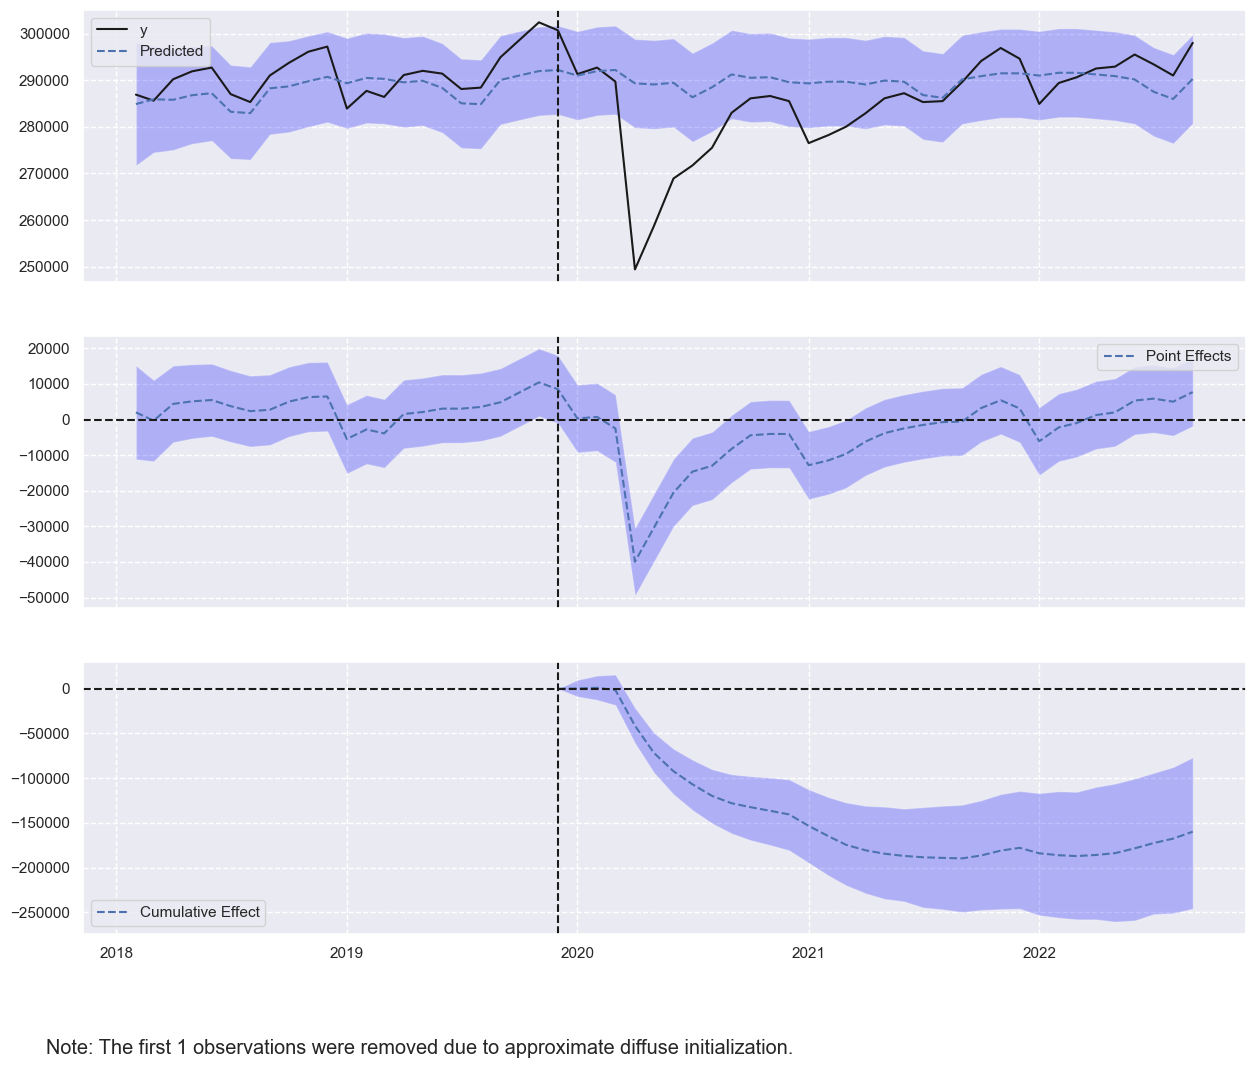

In [357]:
impact.plot()

In [361]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    284975.76          9404200.0
Prediction (s.d.)         289820.3 (1308.11) 9564069.79 (43167.66)
95% CI                    [287301.36, 292429.06][9480944.94, 9650159.07]

Absolute effect (s.d.)    -4844.54 (1308.11) -159869.79 (43167.66)
95% CI                    [-7453.31, -2325.6][-245959.07, -76744.94]

Relative effect (s.d.)    -1.67% (0.45%)     -1.67% (0.45%)
95% CI                    [-2.57%, -0.8%]    [-2.57%, -0.8%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Causa lImpact Analysis findings

During the post-intervention period, the response variable had
an average value of approx. 284975.76. By contrast, in the absence of an
intervention, we would have expected an average response of 289820.3.
The 95% interval of this counterfactual prediction is [287301.36, 292429.06].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -4844.54 with a 95% interval of
[-7453.31, -2325.6]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 9404200.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 9564069.79. The 95% interval of this prediction is [9480944.94, 9650159.07]. 


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -1.67%. The 95%
interval of this percentage is [-2.57%, -0.8%]. This means that the negative effect observed during the intervention
period is statistically significant. The probability of obtaining this effect by chance is very small
(Bayesian one-sided tail-area probability p = 0.0).
This means the causal effect can be considered statistically
significant.